8792
8968


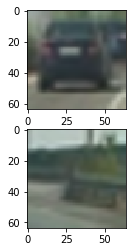

In [1]:
%matplotlib inline
import os
import cv2
from matplotlib import pyplot as plt


def load_images(dir):
    rv = []
    for dirpath, dirnames, filenames in os.walk(dir):
        for fn in sorted(filenames):
            if fn.endswith('.png'):
                imdata = cv2.imread(os.path.join(dirpath, fn))
                imdata = cv2.cvtColor(imdata, cv2.COLOR_BGR2RGB)
                rv.append(imdata)
    
    return rv


vehicles_unshuffled = load_images('vehicles')
non_vehicles_unshuffled = load_images('non-vehicles')

print(len(vehicles_unshuffled))
print(len(non_vehicles_unshuffled))
_, (ax1, ax2) = plt.subplots(2)
ax1.imshow(vehicles_unshuffled[0])
ax2.imshow(non_vehicles_unshuffled[1])

In [2]:
import itertools
import random


def block_shuffle(l, block_size, random=random):
    blocks = list(itertools.zip_longest(*[iter(l)]*block_size))
    blocks[-1] = [im for im in blocks[-1] if im is not None]
    random.shuffle(blocks)
    return list(itertools.chain.from_iterable(blocks))

# in GTI dataset, vehicles typically appear for up to 15 frames. So, we do a block shuffle with block size
# 15.
vehicles_shuffled = block_shuffle(vehicles_unshuffled, 15)
non_vehicles_shuffled = block_shuffle(non_vehicles_unshuffled, 15)

assert all(im.shape == (64, 64, 3) for im in vehicles_shuffled + non_vehicles_shuffled)

print(len(vehicles_shuffled))
print(len(non_vehicles_shuffled))

8792
8968


In [3]:
import sklearn.model_selection

vehicles_train, vehicles_test = sklearn.model_selection.train_test_split(vehicles_shuffled, shuffle=False)
non_vehicles_train, non_vehicles_test = sklearn.model_selection.train_test_split(
    non_vehicles_shuffled, shuffle=False)

2916
2916


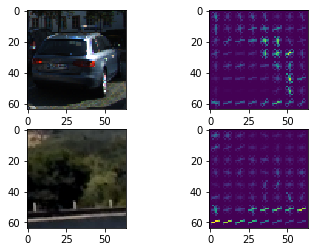

In [26]:
import skimage.feature
from cached_property import cached_property


class FeatureExtractor:
    PIXELS_PER_CELL = 8
    CELLS_PER_BLOCK = 3

    def __init__(self, img):
        self.img = img
    
    @cached_property
    def gray(self):
        return cv2.cvtColor(self.img, cv2.COLOR_RGB2GRAY)

    def do_hog(self, visualise=False):
        return skimage.feature.hog(self.gray, block_norm='L2-Hys', visualise=visualise)

    @cached_property
    def hog(self):
        return self.do_hog()
    
    @cached_property
    def hog_viz(self):
        return self.do_hog(visualise=True)[1]


_, axes = plt.subplots(2, 2)
axes[0][0].imshow(vehicles_train[0])
axes[0][1].imshow(FeatureExtractor(vehicles_train[0]).hog_viz)
axes[1][0].imshow(non_vehicles_train[0])
axes[1][1].imshow(FeatureExtractor(non_vehicles_train[0]).hog_viz)
print(FeatureExtractor(vehicles_train[0]).hog.shape[0])
print(6*6*3*3*9)

In [5]:
%%time
x = [FeatureExtractor(im).hog for im in vehicles_train + non_vehicles_train]

CPU times: user 21 s, sys: 137 ms, total: 21.1 s
Wall time: 21.1 s


In [6]:
%%time
import sklearn.svm

clf = sklearn.svm.SVC(kernel='linear')

y = [1] * len(vehicles_train) + [0] * len(non_vehicles_train)

clf.fit(x, y)

CPU times: user 4min 4s, sys: 113 ms, total: 4min 4s
Wall time: 4min 4s


In [10]:
%%time
import numpy as np

x_test = [FeatureExtractor(im).hog for im in vehicles_test + non_vehicles_test]
y_test = np.array([1] * len(vehicles_test) + [0] * len(non_vehicles_test))

CPU times: user 6.34 s, sys: 23.3 ms, total: 6.36 s
Wall time: 6.36 s


In [11]:
%%time
yhat_test = clf.predict(x_test)

CPU times: user 1min 16s, sys: 10 ms, total: 1min 16s
Wall time: 1min 16s


In [13]:
acc = np.average(yhat_test == y_test)
acc_pct = acc * 100
print(f'Test accuracy: {acc_pct:.2f}%')

Test accuracy: 92.27%


In [16]:
import math

def calc_scales(min, max, num, exp=False):
    # if exp is True, does exponential scales, otherwise linear
    if exp:
        min, max = np.log([min, max])
    x = list(range(num))
    xp = [0, num - 1]
    yp = [min, max]
    rv = np.interp(x, xp, yp)
    if exp:
        rv = np.exp(rv)
    return list(rv)


class FrameProcessor:
    MIN_SIZE = 64
    MAX_SIZE = 314
    MIN_SCALE = 1
    MAX_SCALE = MAX_SIZE / MIN_SIZE
    NUM_SCALES = 5
    EXP = True
    SCALES = calc_scales(MIN_SCALE, MAX_SCALE, NUM_SCALES, exp=EXP)

    MIN_Y = 410
    MAX_Y = 658
    # these MIN_X and MAX_X values assume car is in the leftmost lane
    MIN_X = 562  # applies to MIN_Y row
    MAX_X = 1222 # applies to MIN_Y row

    PIXELS_PER_WINDOW = 64
    WINDOW_OVERLAP_CELLS = 2
    CELLS_PER_WINDOW = self.PIXELS_PER_WINDOW // self.PIXELS_PER_CELL

    def __init__(self, path=None, img=None):
        if (path is None) == (img is None):
            raise Exception('must pass exactly one of path and img')
        
        if path:
            self.img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        else:
            self.img = img
    
    def windows(self):
        # returns tuples of (scale_num, min_block_x, min_block_y, max_block_x, max_block_y)
        # assumes were indexing into a scaled version of the cropped image
        rv = []
        for scale_num in range(self.NUM_SCALES):
            scale = self.SCALES[scale_num]
            width = self.gray.shape[1] // scale
            height = (self.MAX_Y - self.MIN_Y) // scale
            
            window_step = self.PIXELS_PER_CELL * self.WINDOW_OVERLAP_CELLS
            windows_x = (width - self.PIXELS_PER_WINDOW) // window_step + 1
            windows_y = (height - self.PIXELS_PER_WINDOW) // window_step + 1
            
            for wx in range(windows_x):
                for wy = range(windows_y):
                    rv.append((
                        scale_num,
                        wx * self.WINDOW_OVERLAP_CELLS,
                        wy * self.WINDOW_OVERLAP_CELLS,
                        wx * self.WINDOW_OVERLAP_CELLS + self.CELLS_PER_WINDOW - self.CELLS_PER_BLOCK,
                        wy * self.WINDOW_OVERLAP_CELLS + self.CELLS_PER_WINDOW - self.CELLS_PER_BLOCK,
                    ))
        
        return rv
    

print(FrameProcessor.SCALES)
    

[1.0, 1.4882895025275389, 2.2150056433336691, 3.296569647012757, 4.90625]
